In [36]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Load your time series dataset
data = pd.read_csv("C:/Users/raulp/OneDrive/Documenten/KU Leuven/Master HIRB/Thesis/sens_RUL_generated_just.csv")

# Columns to convert to numeric
numeric_columns = ["RMSVibration.mean", "Temperature.mean", "SpeedPeak.mean", "Kurtosis.mean",
                   "RMSAcceleration.mean", "Skewness.mean", "MaximumAbsoluteVibration.mean"]

# Use "." as decimal seperator instead of ","
for col in numeric_columns:
    data[col] = data[col].str.replace(',', '.')

# Convert selected columns to numeric
# Parameter errors="coerce" converts problematic values into NaN
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors="coerce")

# FEATURE ENGINEERING
# Create a column 'Date' on which the data can be aggregated
data['Timestamp'] = pd.to_datetime(data['ReadableDate'], errors="raise")
data['DayOfYear'] = data['Timestamp'].dt.dayofyear
data['Year'] = data['Timestamp'].dt.year
data['Date'] = data['Year'].astype(str) + ' ' + data['DayOfYear'].astype(str).str.zfill(3)

# Make sure we only keep the column 'Date'
data = data.drop(['ReadableDate', 'Timestamp', 'DayOfYear', 'Year'], axis=1)

# Drop other columns that are not needed in the analysis #, 'Skewness.mean'
data = data.drop(['Unnamed: 0', 'Time', 'TrueRUL'], axis=1)

# Aggregate data into 1 observation per day
data = data.groupby('Date').agg(['median', 'std'])

# Flatten the MultiIndex columns (without this, columns are grouped)
data.columns = ['_'.join(col).strip() for col in data.columns.values]
# Drop "FloatRUL_std", created when aggregating but not useful in the analysis: target = "FloatRUL_median"
data = data.drop('FloatRUL_std', axis=1)

cols = data.columns.difference(['FloatRUL_median'])

# Feature 1: Lags and deltas of the attributes
for i in range(1, 3):
    for col in cols:
        data[f'{col}_Lag{i}'] = data[col].shift(i)
        data[f'{col}_Lag{i}'][i - 1] = data[col][i - 1]
        data[f'{col}_Delta{i}'] = data[col] - data[f'{col}_Lag{i}']

# Feature 2: Rolling statistics
window_size = 42
for column in cols:
    data[f'{column}_RollingMean'] = data[column].rolling(window=window_size, min_periods=1).mean()
    data[f'{column}_RollingStd'] = data[column].rolling(window=window_size, min_periods=1).std()
    data[f'{column}_RollingMin'] = data[column].rolling(window=window_size, min_periods=1).min()
    data[f'{column}_RollingMax'] = data[column].rolling(window=window_size, min_periods=1).max()
    data[f'{column}_RollingStd'][0] = 0

# Drop rows with missing values, which may be created after adding features
data = data.dropna()

In [37]:
# Assume the 'FloatRUL_mean' column is your target variable, and other columns are features
X = data.drop(['FloatRUL_median'], axis=1)
y = data['FloatRUL_median']

# Use the oldest data for training, then the next portion for validation, and the newest for testing
# Split: 70-15-15
train_size = int(0.70* len(data))
val_size = int(0.15 * len(data))
train_data, val_data, test_data = data[:train_size], data[train_size:train_size+val_size], data[train_size+val_size:]

# Split the data into features (X) and target variable (y)
X_train, y_train = train_data.drop('FloatRUL_median', axis=1), train_data['FloatRUL_median']
X_val, y_val = val_data.drop('FloatRUL_median', axis=1), val_data['FloatRUL_median']
X_test, y_test = test_data.drop('FloatRUL_median', axis=1), test_data['FloatRUL_median']

In [5]:
from math import sqrt
# Build the RF model
model = RandomForestRegressor(n_estimators=350, n_jobs=-1, max_features="sqrt", random_state=42)

model.fit(X_train, y_train)

# Make predictions on the validation set
val_predictions = model.predict(X_val)
val_mse = mean_squared_error(y_val, val_predictions)
val_rmse = sqrt(val_mse)
print(f'Validation RMSE: {val_rmse}')

# Make predictions on the test set
test_predictions = model.predict(X_test)
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = sqrt(test_mse)
print(f'Test RMSE: {test_rmse}')


Validation RMSE: 23.05955584363225
Test RMSE: 28.789390603136702


In [4]:
# Check feature importances

feature_importances = model.feature_importances_
feature_names = X_train.columns

imp = []
for feature, importance in zip(feature_names, feature_importances):
    imp.append([feature, importance])

def keyFunc(mtx):
    return mtx[1]

imp.sort(reverse=True, key=keyFunc)
for elem in imp:
    print(elem)

['Kurtosis.mean_median_RollingStd', 0.07818776072269765]
['SpeedPeak.mean_std_RollingMin', 0.060095610411417255]
['Kurtosis.mean_median_RollingMean', 0.05437167253581004]
['SpeedPeak.mean_std_RollingMean', 0.04571025330454923]
['Temperature.mean_std_RollingMean', 0.033782472462759845]
['Temperature.mean_std_RollingMin', 0.03239083016677421]
['Kurtosis.mean_median_RollingMax', 0.032222785643148996]
['Temperature.mean_std_RollingMax', 0.024017368757540253]
['Skewness.mean_std_RollingStd', 0.023447081385493184]
['Kurtosis.mean_std_RollingMax', 0.021522719657339068]
['RMSVibration.mean_median_RollingMax', 0.021449615417006043]
['RMSAcceleration.mean_median_RollingMax', 0.021052156043550922]
['MaximumAbsoluteVibration.mean_std_RollingStd', 0.020603688168494463]
['Kurtosis.mean_std_RollingStd', 0.01976552942886575]
['Skewness.mean_std_RollingMax', 0.01842932753221796]
['RMSVibration.mean_std_RollingMin', 0.017806935036369088]
['SpeedPeak.mean_std_RollingMax', 0.016366702423733524]
['Temperat

In [17]:
from sklearn.model_selection import ParameterGrid

estimators = []
for i in range(50, 410, 10):
    estimators.append(i)

samplessplit = []
for i in range(2, 13):
    samplessplit.append(i)

param_grid = {"n_estimators": estimators,
              "max_features": ["sqrt", "log2"],
              "min_samples_split": samplessplit,
              "n_jobs": [-1],
              "random_state": [42]}

param_grid = ParameterGrid(param_grid)
best_score = float('-inf')
best_params = None
rf = RandomForestRegressor()
for i, params in enumerate(param_grid, start=1):
    rf.set_params(**params)
    rf.fit(X_train, y_train)
    score = rf.score(X_val, y_val)
    print(f'Iteration {i}/{len(param_grid)} - Parameters: {params}, Score: {score}')
    if score > best_score:
        best_score = score
        best_params = params
best_rf_model = RandomForestRegressor()
best_rf_model.set_params(**best_params)
best_rf_model.fit(X_train, y_train)

Iteration 1/792 - Parameters: {'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 50, 'n_jobs': -1, 'random_state': 42}, Score: -12.110694012771637
Iteration 2/792 - Parameters: {'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 60, 'n_jobs': -1, 'random_state': 42}, Score: -12.449610416538265
Iteration 3/792 - Parameters: {'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 70, 'n_jobs': -1, 'random_state': 42}, Score: -12.527758819810824
Iteration 4/792 - Parameters: {'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 80, 'n_jobs': -1, 'random_state': 42}, Score: -12.514999819312763
Iteration 5/792 - Parameters: {'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 90, 'n_jobs': -1, 'random_state': 42}, Score: -12.707826076270894
Iteration 6/792 - Parameters: {'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}, Score: -12.549142684253155
Iteration 7/792 - Parameters: {'m

RandomForestRegressor(max_features='sqrt', min_samples_split=7, n_estimators=50,
                      n_jobs=-1, random_state=42)

In [18]:
print("R2 train set:", model.score(X_train, y_train))
print("R2 validation set:", model.score(X_val, y_val))
print("R2 test set:", model.score(X_test, y_test))

print("\nBest model according to Grid Search:")
print("R2 train set:", best_rf_model.score(X_train, y_train))
print("R2 validation set:", best_rf_model.score(X_val, y_val))
print("R2 test set:", best_rf_model.score(X_test, y_test))

R2 train set: 0.9747455953970419
R2 validation set: -13.649756384694312
R2 test set: -35.793688206580036

Best model according to Grid Search:
R2 train set: 0.9556952139046889
R2 validation set: -10.97255862085611
R2 test set: -27.100704217407245


In [19]:
val_predictions = best_rf_model.predict(X_val)
val_mse = mean_squared_error(y_val, val_predictions)
val_rmse = sqrt(val_mse)
print(f'Validation RMSE: {val_rmse}')
print(best_score)
print(best_params)

Validation RMSE: 20.846311484263143
-10.97255862085611
{'max_features': 'sqrt', 'min_samples_split': 7, 'n_estimators': 50, 'n_jobs': -1, 'random_state': 42}


In [20]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

def test_architecture(window_size, lags):
    # Load your time series dataset
    data = pd.read_csv("C:/Users/raulp/OneDrive/Documenten/KU Leuven/Master HIRB/Thesis/sens_RUL_generated_just.csv")

    # Columns to convert to numeric
    numeric_columns = ["RMSVibration.mean", "Temperature.mean", "SpeedPeak.mean", "Kurtosis.mean",
                       "RMSAcceleration.mean", "Skewness.mean", "MaximumAbsoluteVibration.mean"]

    # Use "." as decimal seperator instead of ","
    for col in numeric_columns:
        data[col] = data[col].str.replace(',', '.')

    # Convert selected columns to numeric
    # Parameter errors="coerce" converts problematic values into NaN
    data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors="coerce")

    # FEATURE ENGINEERING
    # Create a column 'Date' on which the data can be aggregated
    data['Timestamp'] = pd.to_datetime(data['ReadableDate'], errors="raise")
    data['DayOfYear'] = data['Timestamp'].dt.dayofyear
    data['Year'] = data['Timestamp'].dt.year
    data['Date'] = data['Year'].astype(str) + ' ' + data['DayOfYear'].astype(str).str.zfill(3)

    # Make sure we only keep the column 'Date'
    data = data.drop(['ReadableDate', 'Timestamp', 'DayOfYear', 'Year'], axis=1)

    # Drop other columns that are not needed in the analysis #, 'Skewness.mean'
    data = data.drop(['Unnamed: 0', 'Time', 'TrueRUL'], axis=1)

    # Aggregate data into 1 observation per day
    data = data.groupby('Date').agg(['median', 'std'])

    # Flatten the MultiIndex columns (without this, columns are grouped)
    data.columns = ['_'.join(col).strip() for col in data.columns.values]
    # Drop "FloatRUL_std", created when aggregating but not useful in the analysis: target = "FloatRUL_median"
    data = data.drop('FloatRUL_std', axis=1)

    cols = data.columns.difference(['FloatRUL_median'])

    # Feature 1: Lags and deltas of the attributes
    for i in range(1, lags+1):
        for col in cols:
            data[f'{col}_Lag{i}'] = data[col].shift(i)
            data[f'{col}_Lag{i}'][i - 1] = data[col][i - 1]
            data[f'{col}_Delta{i}'] = data[col] - data[f'{col}_Lag{i}']

    # Feature 2: Rolling statistics
    for column in cols:
        data[f'{column}_RollingMean'] = data[column].rolling(window=window_size, min_periods=1).mean()
        data[f'{column}_RollingStd'] = data[column].rolling(window=window_size, min_periods=1).std()
        data[f'{column}_RollingMin'] = data[column].rolling(window=window_size, min_periods=1).min()
        data[f'{column}_RollingMax'] = data[column].rolling(window=window_size, min_periods=1).max()
        data[f'{column}_RollingStd'][0] = 0

    # Drop rows with missing values, which may be created after adding features
    data = data.dropna()
    
    # Assume the 'FloatRUL_mean' column is your target variable, and other columns are features
    X = data.drop(['FloatRUL_median'], axis=1)
    y = data['FloatRUL_median']

    # Split data into train, validation, and test sets: 70-15-15
    train_size = int(0.70 * len(data))
    val_size = int(0.15 * len(data))
    train_data, val_data, test_data = data[:train_size], data[train_size:train_size+val_size], data[train_size+val_size:]

    # Split the data into features (X) and target variable (y)
    X_train, y_train = train_data.drop('FloatRUL_median', axis=1), train_data['FloatRUL_median']
    X_val, y_val = val_data.drop('FloatRUL_median', axis=1), val_data['FloatRUL_median']
    X_test, y_test = test_data.drop('FloatRUL_median', axis=1), test_data['FloatRUL_median']
    
    best_rf_model = RandomForestRegressor(max_features='sqrt', min_samples_split=7, n_estimators=50, n_jobs=-1, random_state=42)
    best_rf_model.fit(X_train, y_train)

    # Make predictions on the validation set
    val_predictions = best_rf_model.predict(X_val)
    val_mse = mean_squared_error(y_val, val_predictions)
    val_rmse = sqrt(val_mse)
    
    return val_rmse, best_rf_model.score(X_val, y_val)



In [21]:
bestrmse = 99
for i in range(2, 61):
    for j in range(2, 11):
        rmse, score = test_architecture(i, j)
        print(f'window size {i} & {j} lags: RMSE = {rmse}, R2 = {score}')
        if rmse < bestrmse:
            bestrmse = rmse
            bestscore = score
            bestwindow = i
            bestlags = j
print(f'Best results: window size {bestwindow} & {bestlags} lags: RMSE = {bestrmse}, R2 = {bestscore}')

window size 2 & 2 lags: RMSE = 24.479641953222416, R2 = -15.50967977083057
window size 2 & 3 lags: RMSE = 25.10669376528654, R2 = -16.366311133178034
window size 2 & 4 lags: RMSE = 25.677491137085717, R2 = -17.16492891869747
window size 2 & 5 lags: RMSE = 24.84073917448197, R2 = -17.610499544352656
window size 2 & 6 lags: RMSE = 25.48493164874176, R2 = -18.588263943913752
window size 2 & 7 lags: RMSE = 25.19395404070849, R2 = -18.14351428088363
window size 2 & 8 lags: RMSE = 25.05824224579664, R2 = -17.937829744088713
window size 2 & 9 lags: RMSE = 25.513712182638947, R2 = -20.70404716293391
window size 2 & 10 lags: RMSE = 25.64326272135406, R2 = -20.92501929139341
window size 3 & 2 lags: RMSE = 24.539632397611502, R2 = -15.590697018241652
window size 3 & 3 lags: RMSE = 24.774794946077435, R2 = -15.91019688332456
window size 3 & 4 lags: RMSE = 25.363458509657587, R2 = -16.72333605572027
window size 3 & 5 lags: RMSE = 25.86162384803355, R2 = -19.1716109089731
window size 3 & 6 lags: RMS

In [38]:
from math import sqrt

# Combine train and validation sets (resulting in a 85-15 split) in order to report final results
train_data_final, test_data_final = data[:train_size+val_size], data[train_size+val_size:]

# Split the data into features (X) and target variable (y)
X_train_final, y_train_final = train_data_final.drop('FloatRUL_median', axis=1), train_data_final['FloatRUL_median']
X_test_final, y_test_final = test_data_final.drop('FloatRUL_median', axis=1), test_data_final['FloatRUL_median']

# Train the model
best_rf_model.fit(X_train_final, y_train_final)

# Evaluate on the test set
test_predictions = best_rf_model.predict(X_test_final)
test_rmse = sqrt(mean_squared_error(y_test_final, test_predictions))
print(f'Test RMSE: {test_rmse}')
print("R2 test set:", best_rf_model.score(X_test_final, y_test_final))

Test RMSE: 8.61542444460391
R2 test set: -2.2950479268635533


In [41]:
y_test_final_reset = y_test_final.reset_index(drop=True)

# Convert the arrays to pandas Series
predictions_series = pd.Series(test_predictions, name="Predictions")
true_values_series = pd.Series(y_test_final_reset, name="True values")

# Concatenate the Series into a single DataFrame
df = pd.concat([predictions_series, true_values_series], axis=1)

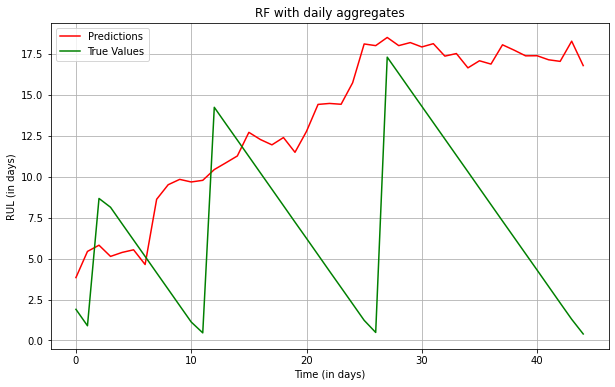

In [43]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.plot(test_predictions, label='Predictions', color='red')
plt.plot(y_test_final_reset, label='True Values', color='green')
plt.xlabel('Time (in days)')
plt.ylabel('RUL (in days)')
plt.title('RF with daily aggregates')
plt.legend(loc='upper left')
plt.grid(True)

plt.savefig("Plot daily aggregates.pdf")

plt.show()